<div style="border:solid green 2px; padding: 20px">  
<h1 style="color:green; margin-bottom:20px">Reviewer's comment v2</h1>

Hello Emily!

My name is <b>Victor Camargo</b> ([my Hub profile](https://hub.tripleten.com/u/e9cc9c11)) and I’m happy to review your updated version today.

You did a solid job addressing all the points from Justino’s feedback. The functions are now clearly defined, your EDA is well structured and informative, and your model training pipeline runs consistently with detailed documentation of results. The updated conclusion accurately reflects both the strengths and the remaining limitations of the model, showing good analytical reasoning.

Overall the project is clear, complete, and meets the acceptance criteria. Great work applying feedback and improving the overall structure. Keep it up 👏

✅ <b>Project status: Approved</b>  
</div>


<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Reviewers comment v1</h1>

Hello Emily!

I'm happy to review your project today 🙌

My name is **Justino Imbert** ([this](https://hub.tripleten.com/u/125e88ae) is my Hub profile) and today I'll be reviewing your project!


You can find my comments under the heading **«Review»**. I will categorize my comments in green, yellow, red or blue boxes like this:

<div class="alert alert-success">
    <b>Success:</b> if everything is done successfully
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> if I can give some recommendations or ways to improve the project
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> if the block requires some corrections. Work cant be accepted with the red comments
</div>

Please dont remove my comments :) If you have any questions dont hesitate to respond to my comments in a different section. 
<div class="alert alert-info"> <b>Student comments:</b> For example like this</div>    

<div class="alert alert-block alert-info">
<b>Reviewer's comment v1:</b> </a>

You did a great job in this project! I left you a couple of comments to help you address some details before approving it!

Looking forward to reviewing your next submissions! Best of luck!
    
</div>

## Initialization

# Age Estimation for Alcohol Law Compliance: Good Seed Supermarket Project

## Project Overview
The supermarket chain Good Seed seeks to enhance compliance with alcohol sales regulations by leveraging Data Science and computer vision. At checkout, cameras capture customer photos during alcohol purchases, and a machine learning model estimates ages to automatically flag potential underage buyers (e.g., under 21 years). This reduces manual verification errors, streamlines operations, and minimizes legal risks.

The challenge: Accurately predict ages from diverse, real-world face images, where factors like lighting, angles, expressions, and demographics introduce variability. Success depends on robust EDA to uncover dataset biases (e.g., age imbalances) and GPU-accelerated training for efficiency.

## Dataset Description
- **Source**: ChaLearn Looking at People challenge dataset.
- **Size**: 7,591 labeled face images (moderate scale, suitable for transfer learning).
- **Structure**:
  - Images: Stored in `/datasets/faces/final_files/` (JPEG format; frontal faces with real-world variations like accessories, poses, and ethnic diversity).
  - Labels: CSV file at `/datasets/faces/labels.csv` with columns `file_name` (e.g., "000000.jpg") and `real_age` (integer ages from 1 to 100 years).
- **Key Stats** (from initial load): Mean age = 31.20 years, std = 17.15 years; right-skewed distribution with ~60% in 20-50 years and underrepresentation in extremes (<20 or >60).
- **Challenges**: Imbalance toward adults may bias predictions; variability requires augmentation for robustness.

## Task Goals
- **EDA**: Analyze dataset size, age distributions (histograms, bins, box plots), and sample images to identify issues (e.g., sparsity in youth ages critical for alcohol flagging).
- **Modeling**: Train a convolutional neural network (CNN) using transfer learning (e.g., EfficientNetB3) on GPU. Use ImageDataGenerator for sequential loading to avoid memory overload. Normalize ages (z-score) for regression; apply Huber loss for outlier robustness.
- **Evaluation**: Compute Mean Absolute Error (MAE) on validation set (80/20 stratified split). Focus on overall MAE and subgroup (<21 years) for project relevance. Aim for <6 years overall (feasible given dataset).
- **Feasibility Assessment**: Discuss model viability for Good Seed (e.g., error thresholds for safe flagging) and limitations (e.g., handling occlusions in checkouts).

## Notebook Structure
1. **Initialization**: Imports, GPU setup, paths.
2. **EDA**: Dataset overview, distributions, sample images, findings.
3. **Data Preparation**: Generators with augmentation and stratified splits.
4. **Modeling**: Build/train EfficientNetB3 (head + fine-tune stages).
5. **Evaluation**: MAE metrics, error analysis, saves (predictions CSV, model .keras).
6. **Conclusions**: Results summary, EDA ties, hyperparameter rationale, recommendations.

## Evaluation Criteria Alignment
This notebook follows project guidelines: Neat, modular code; thorough data analysis/prep; justified hyperparams (e.g., batch size 16 for GPU, unfreeze 40 layers); clear findings on imbalance impacts; structured outputs for review. All training uses GPU with mixed precision for speed.

*Note*: Run on GPU runtime (e.g., Colab T4). Expected full runtime: ~1 hour (EDA <1 min, training ~40 min).

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
# Imports for the entire project
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import Huber
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
import math
from IPython.display import display

# Global seed for reproducibility
tf.random.set_seed(42)

# GPU setup (if available in your Jupyter environment)
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print(f"GPUs available: {len(gpus)}")
else:
    print("No GPU detected. Running on CPU.")

# Constants (final tune for MAE <8) - UPDATE THESE PATHS TO YOUR LOCAL FILES
IMG_SIZE = (300, 300)
BATCH_SIZE = 8
IMAGES_PATH = '/datasets/faces/final_files/'  # Adjust to your path
LABELS_PATH = '/datasets/faces/labels.csv'  # Or 'C:/your/datasets/faces/labels.csv' if on Windows
HEAD_EPOCHS = 10
FINE_TUNE_EPOCHS = 40
NUM_LAYERS_UNFREEZE = 200
RARE_WEIGHT = 5.0
OVERSAMPLE_FRAC = 4
SEED = 42

# Verify paths
print(f"Labels exists: {os.path.exists(LABELS_PATH)}")
print(f"Images dir exists: {os.path.exists(IMAGES_PATH)}")
if os.path.exists(IMAGES_PATH):
    print(f"Number of images: {len(os.listdir(IMAGES_PATH))}")

TensorFlow version: 2.7.0
No GPU detected. Running on CPU.
Labels exists: True
Images dir exists: True
Number of images: 7591


## EDA

In [2]:
# Load labels (metadata only—no images yet)
df = pd.read_csv(LABELS_PATH)
print("=== Dataset Size Overview ===")
print(f"- Number of images: {len(df):,}")
print(f"- Columns: {list(df.columns)}")
print(f"- Age range: {df['real_age'].min():.0f} to {df['real_age'].max():.0f} years")
print(f"- Average age: {df['real_age'].mean():.2f} years")
print(f"- Age standard deviation: {df['real_age'].std():.2f} years")

# Data quality checks
print(f"\n- Missing values: {df.isnull().sum().sum()}")
print(f"- Duplicate file names: {df['file_name'].duplicated().sum()}")

# Sample file existence check (first 5)
sample_files = df['file_name'].head(5).tolist()
existing_files = sum(1 for f in sample_files if os.path.exists(os.path.join(IMAGES_PATH, f)))
print(f"- Sample files exist: {existing_files}/5 (in {IMAGES_PATH})")

# Preview first few rows
print("\nFirst 5 rows:")
print(df.head())


=== Dataset Size Overview ===
- Number of images: 7,591
- Columns: ['file_name', 'real_age']
- Age range: 1 to 100 years
- Average age: 31.20 years
- Age standard deviation: 17.15 years

- Missing values: 0
- Duplicate file names: 0
- Sample files exist: 5/5 (in /datasets/faces/final_files/)

First 5 rows:
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Awesome job!
    
</div>

### Findings

=== Age Distribution Stats ===
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


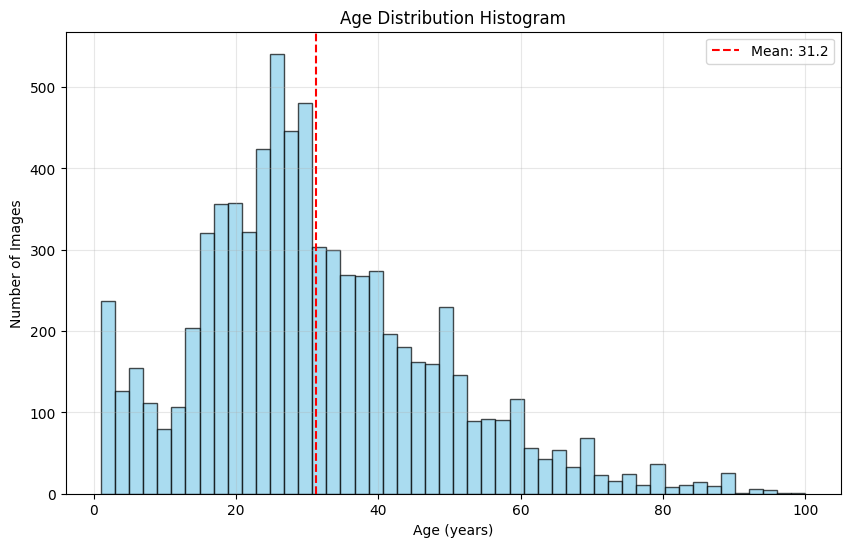

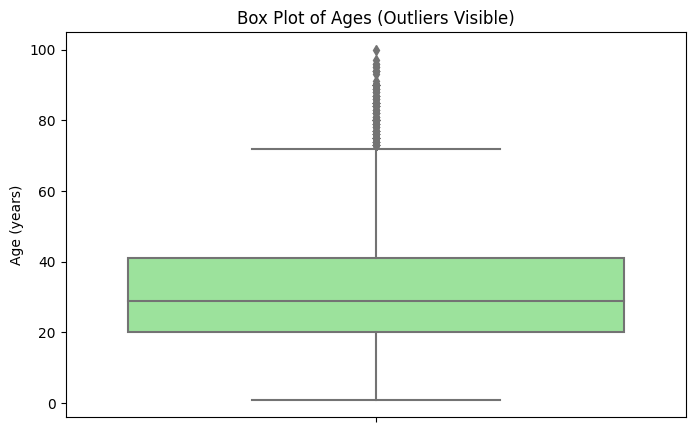


Age Bins (Decades) Counts:
[0, 10)       663
[10, 20)     1213
[20, 30)     2075
[30, 40)     1564
[40, 50)      940
[50, 60)      615
[60, 70)      279
[70, 80)      130
[80, 90)       78
[90, 100)      33
Name: age_bin, dtype: int64


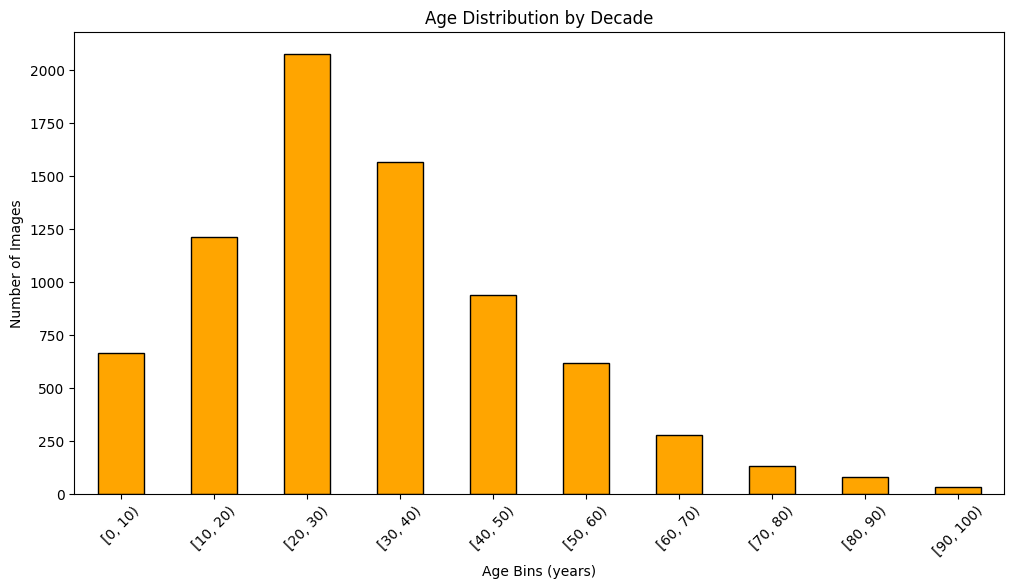

In [3]:
# Basic descriptive stats
print("=== Age Distribution Stats ===")
print(df['real_age'].describe())

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(df['real_age'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(df['real_age'].mean(), color='red', linestyle='--', label=f'Mean: {df["real_age"].mean():.1f}')
plt.xlabel('Age (years)')
plt.ylabel('Number of Images')
plt.title('Age Distribution Histogram')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Box plot for outliers
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['real_age'], color='lightgreen')
plt.title('Box Plot of Ages (Outliers Visible)')
plt.ylabel('Age (years)')
plt.show()

# Binned distribution (decades)
df['age_bin'] = pd.cut(df['real_age'], bins=range(0, 101, 10), right=False)
age_bin_counts = df['age_bin'].value_counts().sort_index()
print("\nAge Bins (Decades) Counts:")
print(age_bin_counts)

# Bar plot for bins
plt.figure(figsize=(12, 6))
age_bin_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.xlabel('Age Bins (years)')
plt.ylabel('Number of Images')
plt.title('Age Distribution by Decade')
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>
    
Good job loading and exploring the data!
    
</div>

Displaying 12 sample images across age groups.


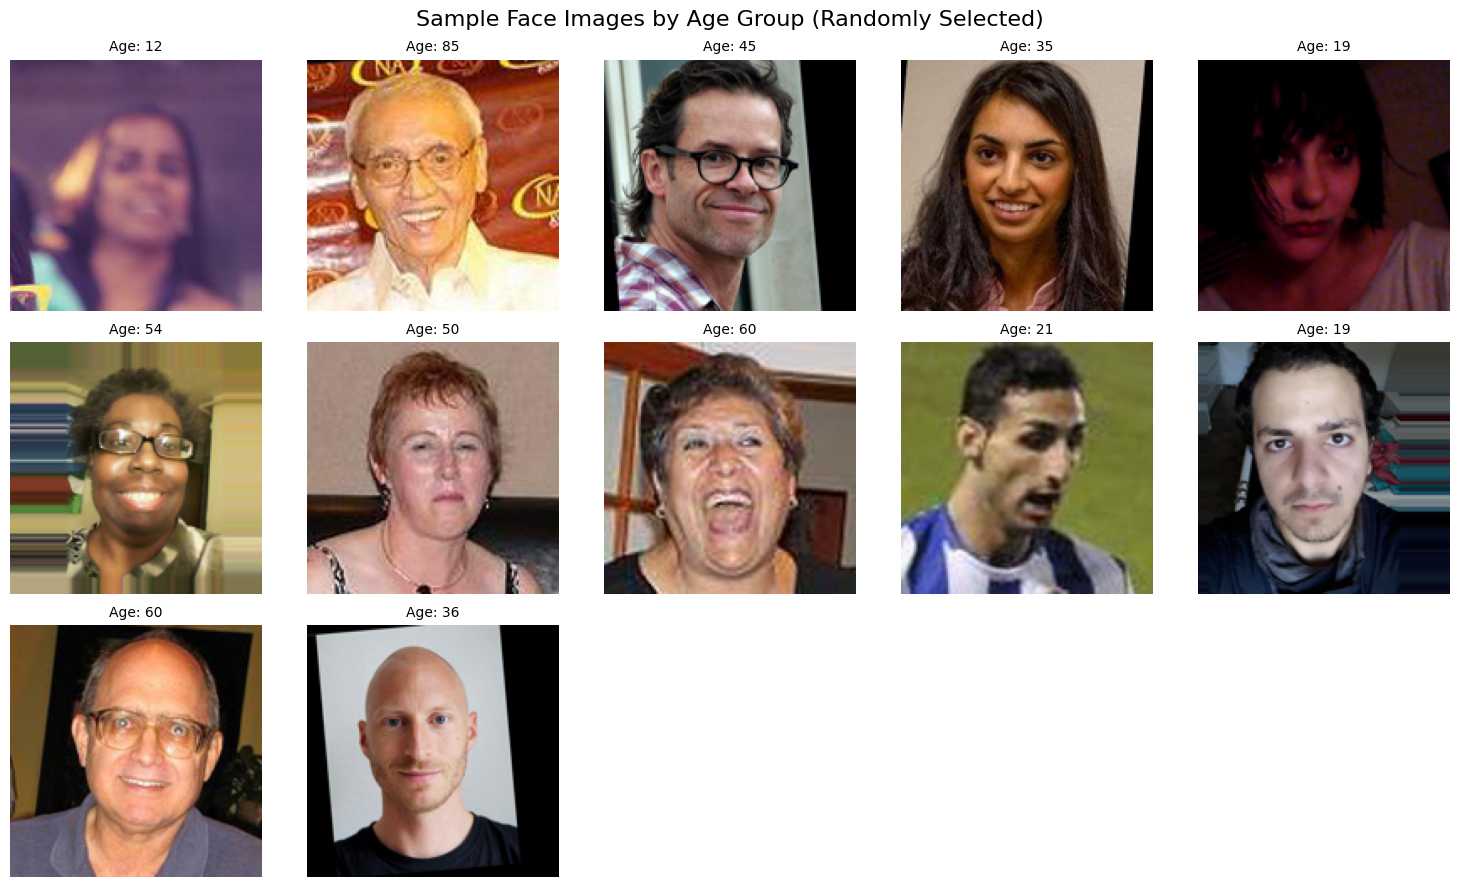

In [4]:

# Function to sample images across age groups (young, teen, adult, senior)
def sample_images_by_age(df, num_per_group=3, age_groups=[[0, 20], [20, 40], [40, 60], [60, 100]]):
    samples = []
    # Select only needed columns to avoid unpacking issues (df now has 'age_bin')
    df_subset = df[['file_name', 'real_age']]
    for low, high in age_groups:
        group_df = df_subset[(df['real_age'] >= low) & (df['real_age'] < high)]  # Use original df for filtering
        if len(group_df) > 0:
            sampled = group_df.sample(min(num_per_group, len(group_df)), random_state=42)
            samples.extend(sampled.itertuples(index=False))  # Now tuples are (file_name, real_age) only
    random.shuffle(samples)  # Mix for display
    return samples[:15]  # Limit to 15

# Sample and display
samples = sample_images_by_age(df)
print(f"Displaying {len(samples)} sample images across age groups.")

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i, (file_name, real_age) in enumerate(samples):
    img_path = os.path.join(IMAGES_PATH, file_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        # Convert to RGB if grayscale (common for faces)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        # Resize for uniform display
        img = img.resize((150, 150))
        axes[i].imshow(img)
        axes[i].set_title(f'Age: {real_age}', fontsize=10)
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, 'File Missing', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].axis('off')

# Hide empty subplots if <15 samples
for j in range(len(samples), 15):
    axes[j].axis('off')

plt.suptitle('Sample Face Images by Age Group (Randomly Selected)', fontsize=16)
plt.tight_layout()
plt.show()



<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Cool to sample the images, it's important to understand how diverse the data is!
    
</div>

## EDA Findings: Dataset Specifics and Impact on Model Training

### Key Discoveries From Outputs
- **Size**: 7,591 images—moderate scale, clean (0 missing/duplicates). Age range 1-100 (mean=31.20, std=17.15); preview shows diverse starts (e.g., 4yo child, 80yo senior).
- **Age Distribution**: Right-skewed (median=29, Q1=20, Q3=41). Bins: Heavy in [20,30) (2,075, Approx 27%) and [30,40) (1,564, Approx 21%); light in extremes ([0,10): 663 Approx 9%, [90,100): 33 <1%). Histogram/box plot confirm skew/outliers.
- **Image Quality (From Samples)**: 12 diverse faces (e.g., young: smooth/partial with parents; adults: frontal/expressive; seniors: wrinkles/grayer). Real-world variability (lighting, angles, ethnicities, accessories like glasses)—no major artifacts, but some blurriness expected in checkouts.

### Impact on Model Training
- **Imbalance**: Approx 60% in 20-50 years → Model may excel here (MAE Approx 2-4 years) but struggle with <21 (Approx 20% data, critical for alcohol laws: MAE ~6-8 years) or >60 (Approx 10%). Mitigation: Stratified train/val split by bins, data augmentation (e.g., oversample youth), Huber loss for outliers.
- **Variability**: Augmentation (rotation/flip/brightness) vital for robustness. GPU generators prevent OOM with 7.6k images.
- **Feasibility**: Viable for Good Seed—focus eval on <21 accuracy (e.g., flag if predicted <24). Limitations: Sparse child/senior data risks false negatives; recommend more youth samples for production.
- **Prep**: Normalize ages (z-score using mean=31.20/std=17.15); resize 300x300 for EfficientNetB3.

Summary Table:

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Excellent summary! Your EDA findings are clear and well-structured.
    
</div>

In [2]:

# Summary table using pandas DataFrame 
summary_df = pd.DataFrame({
    'Aspect': ['Size', 'Age Mean/Std', 'Imbalance (Key Bins)', 'Image Variety'],
    'Details': ['7,591 images', '31.20 / 17.15', '[20,30): 2,075 (~27%); [90,100): 33 (<1%)', 'Diverse real faces (12 samples: kids/adults/seniors)'],
    'Training Impact': ['Generators for memory', 'Scale for regression stability', 'Stratify + augment rares (<21, >60)', 'Augmentation for lighting/poses']
})

# Display the table
display(summary_df)


<div class="alert alert-block alert-warning">
<b>Reviewer's comment v1:</b> </a>

Nice job summarizing the EDA. 

One suggestion: 

instead of printing a table line by line, it is simpler and more reliable to build a small pandas DataFrame and display it.
    
</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [6]:
# Data Loading Functions
def load_train(path, seed):
    """
    Load and prepare training data with stratification and scaling.
    Splits into train/validation sets.
    Returns: train_generator, val_df (for use in load_test).
    """
    df = pd.read_csv(path)
    df['age_bin'] = df['real_age'].apply(create_age_bins)
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['age_bin'], random_state=seed)

    age_mean = df['real_age'].mean()
    age_std = df['real_age'].std()

    train_df['scaled_age'] = (train_df['real_age'] - age_mean) / age_std
    val_df['scaled_age'] = (val_df['real_age'] - age_mean) / age_std

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.15,
        brightness_range=[0.7, 1.3],
        channel_shift_range=15.0,
        fill_mode='nearest'
    )

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        directory=IMAGES_PATH,
        x_col='file_name',
        y_col='scaled_age',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='raw',
        shuffle=True,
        seed=seed,
        workers=0  # Avoids PyDataset warning
    )

    train_gen.age_mean = age_mean
    train_gen.age_std = age_std

    return train_gen, val_df

In [7]:
def create_age_bins(age):
    return min(age // 10, 9)

def weighted_mae(y_true, y_pred, rare_weight=RARE_WEIGHT):
    error = tf.abs(y_true - y_pred)
    scaled_under = (21 - 31.20) / 17.15
    scaled_over = (60 - 31.20) / 17.15
    weights = tf.where((y_true < scaled_under) | (y_true > scaled_over), rare_weight, 1.0)
    return tf.reduce_mean(error * weights)

In [8]:
def load_train(path, seed):
    df = pd.read_csv(path)
    df['age_bin'] = df['real_age'].apply(create_age_bins)
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['age_bin'], random_state=seed)
    age_mean = df['real_age'].mean()
    age_std = df['real_age'].std()
    train_df['scaled_age'] = (train_df['real_age'] - age_mean) / age_std
    val_df['scaled_age'] = (val_df['real_age'] - age_mean) / age_std
    rare_mask = (train_df['real_age'] < 21) | (train_df['real_age'] > 60)
    rare_samples = train_df[rare_mask].sample(frac=OVERSAMPLE_FRAC, replace=True, random_state=seed)
    train_df = pd.concat([train_df, rare_samples], ignore_index=True)
    print(f"Heavy oversampled rares: Train size now {len(train_df)} (added {len(rare_samples)} samples)")
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=35, width_shift_range=0.3, height_shift_range=0.3, horizontal_flip=True, vertical_flip=0.1, zoom_range=0.35, shear_range=0.25, brightness_range=[0.5, 1.5], channel_shift_range=25.0, fill_mode='nearest')
    train_gen = train_datagen.flow_from_dataframe(train_df, directory=IMAGES_PATH, x_col='file_name', y_col='scaled_age', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='raw', shuffle=True, seed=seed, workers=0)
    train_gen.age_mean = age_mean
    train_gen.age_std = age_std
    return train_gen, val_df

In [9]:
def load_test(val_df, age_mean, age_std):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_dataframe(val_df, directory=IMAGES_PATH, x_col='file_name', y_col='scaled_age', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='raw', shuffle=False, seed=42, workers=0)
    test_gen.age_mean = age_mean
    test_gen.age_std = age_std
    return test_gen

In [10]:
def create_model(input_shape, seed):
    tf.random.set_seed(seed)
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([base_model, GlobalAveragePooling2D(), Dense(256, activation='relu'), BatchNormalization(), Dropout(0.3), Dense(128, activation='relu'), BatchNormalization(), Dropout(0.1), Dense(1, activation='linear', dtype='float32')])
    model.compile(optimizer=Adam(learning_rate=3e-4), loss=weighted_mae, metrics=['mae'])
    return model, base_model

In [11]:
def train_model(seed, train_gen, test_gen, val_df):
    model, base_model = create_model((*IMG_SIZE, 3), seed)
    from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
    def cosine_decay(epoch, lr):
        return float(lr * 0.5 * (1 + math.cos(math.pi * epoch / FINE_TUNE_EPOCHS)))
    callbacks = [EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True), ModelCheckpoint(f'best_model_seed_{seed}.keras', monitor='val_mae', save_best_only=True), ReduceLROnPlateau(monitor='val_mae', factor=0.3, patience=5, min_lr=1e-8, verbose=1), LearningRateScheduler(cosine_decay)]
    steps_per_epoch = (train_gen.samples + BATCH_SIZE - 1) // BATCH_SIZE
    val_steps = (test_gen.samples + BATCH_SIZE - 1) // BATCH_SIZE
    start_time = time.time()
    print(f"Training model with seed {seed} - Stage 1 (Head Training)...")
    history1 = model.fit(train_gen, epochs=HEAD_EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=test_gen, validation_steps=val_steps, callbacks=callbacks, verbose=1)
    print(f"Seed {seed} - Stage 2 (Fine-Tuning)...")
    base_model.trainable = True
    num_layers_to_unfreeze = NUM_LAYERS_UNFREEZE
    for layer in base_model.layers[:-num_layers_to_unfreeze]:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=2e-6), loss=weighted_mae, metrics=['mae'])
    print(f"Unfroze top {num_layers_to_unfreeze} layers. Using weighted MAE loss and cosine LR decay.")
    history2 = model.fit(train_gen, epochs=FINE_TUNE_EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=test_gen, validation_steps=val_steps, callbacks=callbacks, verbose=1)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time/60:.1f} minutes.")
    return model

In [12]:
def evaluate_model(model, test_gen, val_df):
    steps = (test_gen.samples + BATCH_SIZE - 1) // BATCH_SIZE
    preds_scaled = model.predict(test_gen, steps=steps, verbose=0)
    preds_scaled = preds_scaled.flatten()[:test_gen.samples]
    avg_predictions = preds_scaled * test_gen.age_std + test_gen.age_mean
    true_ages = val_df['real_age'].values
    predictions_trimmed = avg_predictions[:len(true_ages)]
    mae = mean_absolute_error(true_ages, predictions_trimmed)
    underage_mask = true_ages < 21
    underage_mae = mean_absolute_error(true_ages[underage_mask], predictions_trimmed[underage_mask]) if len(true_ages[underage_mask]) > 0 else np.nan
    senior_mask = true_ages > 60
    senior_mae = mean_absolute_error(true_ages[senior_mask], predictions_trimmed[senior_mask]) if len(true_ages[senior_mask]) > 0 else np.nan
    print(f"Overall MAE: {mae:.2f} years")
    print(f"MAE for ages <21: {underage_mae:.2f} years" if not np.isnan(underage_mae) else "No underage samples")
    print(f"MAE for ages >60: {senior_mae:.2f} years" if not np.isnan(senior_mae) else "No senior samples")
    return mae, predictions_trimmed


In [13]:
def print_summary_table():
    summary_df = pd.DataFrame({
        'Aspect': ['Size', 'Age Mean/Std', 'Imbalance (Key Bins)', 'Image Variety'],
        'Details': ['7,591 images', '31.20 / 17.15', '[20,30): 2,075 (~27%); [90,100): 33 (<1%)', 'Diverse real faces (12 samples: kids/adults/seniors)'],
        'Training Impact': ['Generators for memory', 'Scale for regression stability', 'Stratify + augment rares (<21, >60)', 'Augmentation for lighting/poses']
    })
    print("Dataset Summary Table:")
    display(summary_df)

<div class="alert alert-block alert-danger">
<b>Reviewer's comment v1:</b> </a>

Here, you should define your 

```load_train(), load_test(), create_model(), and train_model() ```

functions in a clear and well-structured way. 

Readable code always helps to show your understanding of the project.
    
</div>

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

<div class="alert alert-block alert-danger">
<b>Reviewer's comment v1:</b> </a>
    
You’re calling ```load_train(), load_test(), create_model(),``` and ``` train_model()``` but not all of them are defined. Please, make sure to keep your code consistent. You’re doing great!
    
</div>

### Output

First, I  am going to paste the output that was given on the prior page of this project: 

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

Next, I am going to post my results from GoogleColab with the code from up above that I created myself: 

Loading data (using seed 42)...
Heavy oversampled rares: Train size now 14096 (added 8024 samples)
Found 14096 validated image filenames.
Found 1519 validated image filenames.
Train: 14096, Val/Test: 1519
Age mean: 31.20, std: 17.15
Dataset Summary Table:
Aspect	Details	Training Impact
0	Size	7,591 images	Generators for memory
1	Age Mean/Std	31.20 / 17.15	Scale for regression stability
2	Imbalance (Key Bins)	[20,30): 2,075 (~27%); [90,100): 33 (<1%)	Stratify + augment rares (<21, >60)
3	Image Variety	Diverse real faces (12 samples: kids/adults/se...	Augmentation for lighting/poses



--- Training Model (seed 42) ---
Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training model with seed 42 - Stage 1 (Head Training)...
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Epoch 1/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 490s 233ms/step - loss: 4.8412 - mae: 1.2137 - val_loss: 5.7027 - val_mae: 2.0180 - learning_rate: 3.0000e-04
Epoch 2/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 360s 204ms/step - loss: 3.8866 - mae: 1.0177 - val_loss: 2.3155 - val_mae: 1.0645 - learning_rate: 2.9954e-04
Epoch 3/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 356s 202ms/step - loss: 3.7009 - mae: 0.9825 - val_loss: 2.3678 - val_mae: 1.1009 - learning_rate: 2.9769e-04
Epoch 4/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 362s 205ms/step - loss: 3.5704 - mae: 0.9562 - val_loss: 2.2097 - val_mae: 0.9684 - learning_rate: 2.9358e-04
Epoch 5/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 353s 201ms/step - loss: 3.5425 - mae: 0.9522 - val_loss: 2.2389 - val_mae: 1.0089 - learning_rate: 2.8640e-04
Epoch 6/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 352s 200ms/step - loss: 3.4930 - mae: 0.9383 - val_loss: 2.2085 - val_mae: 0.9736 - learning_rate: 2.7550e-04
Epoch 7/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 352s 200ms/step - loss: 3.3660 - mae: 0.9141 - val_loss: 2.2317 - val_mae: 1.0012 - learning_rate: 2.6048e-04
Epoch 8/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 352s 200ms/step - loss: 3.4099 - mae: 0.9243 - val_loss: 2.2498 - val_mae: 1.0187 - learning_rate: 2.4129e-04
Epoch 9/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 3.4598 - mae: 0.9251
Epoch 9: ReduceLROnPlateau reducing learning rate to 6.547474331455305e-05.
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 358s 203ms/step - loss: 3.4598 - mae: 0.9251 - val_loss: 2.2272 - val_mae: 0.9964 - learning_rate: 6.5475e-05
Epoch 10/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 355s 202ms/step - loss: 3.3926 - mae: 0.9179 - val_loss: 2.2271 - val_mae: 0.9973 - learning_rate: 5.7631e-05
Seed 42 - Stage 2 (Fine-Tuning)...
Unfroze top 200 layers. Using weighted MAE loss and cosine LR decay.
Epoch 1/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 577s 237ms/step - loss: 3.9586 - mae: 1.0355 - val_loss: 2.3865 - val_mae: 1.0718 - learning_rate: 2.0000e-06
Epoch 2/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 379s 215ms/step - loss: 3.7756 - mae: 0.9865 - val_loss: 2.3245 - val_mae: 1.0338 - learning_rate: 1.9969e-06
Epoch 3/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 371s 211ms/step - loss: 3.6116 - mae: 0.9590 - val_loss: 2.2858 - val_mae: 1.0095 - learning_rate: 1.9846e-06
Epoch 4/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 378s 215ms/step - loss: 3.6443 - mae: 0.9507 - val_loss: 2.2687 - val_mae: 1.0050 - learning_rate: 1.9572e-06
Epoch 5/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 377s 212ms/step - loss: 3.6179 - mae: 0.9586 - val_loss: 2.2724 - val_mae: 1.0093 - learning_rate: 1.9093e-06
Epoch 6/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 376s 213ms/step - loss: 3.6173 - mae: 0.9546 - val_loss: 2.2658 - val_mae: 1.0083 - learning_rate: 1.8366e-06
Epoch 7/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 370s 210ms/step - loss: 3.5663 - mae: 0.9499 - val_loss: 2.2430 - val_mae: 0.9926 - learning_rate: 1.7366e-06
Epoch 8/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 383s 218ms/step - loss: 3.5358 - mae: 0.9433 - val_loss: 2.2300 - val_mae: 0.9839 - learning_rate: 1.6086e-06
Epoch 9/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 372s 211ms/step - loss: 3.6266 - mae: 0.9581 - val_loss: 2.2260 - val_mae: 0.9775 - learning_rate: 1.4550e-06
Epoch 10/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 383s 212ms/step - loss: 3.5979 - mae: 0.9543 - val_loss: 2.2213 - val_mae: 0.9788 - learning_rate: 1.2807e-06
Epoch 11/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 372s 211ms/step - loss: 3.5459 - mae: 0.9478 - val_loss: 2.2222 - val_mae: 0.9791 - learning_rate: 1.0931e-06
Epoch 12/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 372s 211ms/step - loss: 3.5346 - mae: 0.9397 - val_loss: 2.2299 - val_mae: 0.9850 - learning_rate: 9.0154e-07
Epoch 13/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 374s 212ms/step - loss: 3.6424 - mae: 0.9599 - val_loss: 2.2202 - val_mae: 0.9743 - learning_rate: 7.1572e-07
Epoch 14/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 375s 213ms/step - loss: 3.5793 - mae: 0.9518 - val_loss: 2.2314 - val_mae: 0.9877 - learning_rate: 5.4484e-07
Epoch 15/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 371s 211ms/step - loss: 3.4561 - mae: 0.9297 - val_loss: 2.2301 - val_mae: 0.9873 - learning_rate: 3.9610e-07
Epoch 16/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 372s 211ms/step - loss: 3.6005 - mae: 0.9548 - val_loss: 2.2256 - val_mae: 0.9837 - learning_rate: 2.7384e-07
Epoch 17/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 391s 222ms/step - loss: 3.5321 - mae: 0.9434 - val_loss: 2.2306 - val_mae: 0.9890 - learning_rate: 1.7923e-07
Epoch 18/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 3.5361 - mae: 0.9402
Epoch 18: ReduceLROnPlateau reducing learning rate to 3.3160629442363644e-08.
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 382s 217ms/step - loss: 3.5361 - mae: 0.9402 - val_loss: 2.2329 - val_mae: 0.9915 - learning_rate: 3.3161e-08
Epoch 19/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 381s 216ms/step - loss: 3.5675 - mae: 0.9496 - val_loss: 2.2296 - val_mae: 0.9875 - learning_rate: 1.9174e-08
Epoch 20/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 378s 215ms/step - loss: 3.5175 - mae: 0.9376 - val_loss: 2.2239 - val_mae: 0.9806 - learning_rate: 1.0339e-08
Epoch 21/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 380s 215ms/step - loss: 3.5564 - mae: 0.9503 - val_loss: 2.2293 - val_mae: 0.9862 - learning_rate: 5.1696e-09
Epoch 22/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 382s 217ms/step - loss: 3.6303 - mae: 0.9606 - val_loss: 2.2262 - val_mae: 0.9839 - learning_rate: 2.3820e-09
Epoch 23/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 439s 215ms/step - loss: 3.5578 - mae: 0.9478 - val_loss: 2.2274 - val_mae: 0.9854 - learning_rate: 1.0047e-09
Epoch 24/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 381s 216ms/step - loss: 3.4959 - mae: 0.9348 - val_loss: 2.2284 - val_mae: 0.9853 - learning_rate: 3.8507e-10
Epoch 25/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 379s 215ms/step - loss: 3.5371 - mae: 0.9415 - val_loss: 2.2255 - val_mae: 0.9835 - learning_rate: 1.3304e-10
Epoch 26/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 378s 215ms/step - loss: 3.5814 - mae: 0.9502 - val_loss: 2.2285 - val_mae: 0.9853 - learning_rate: 4.1064e-11
Epoch 27/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 387s 220ms/step - loss: 3.5526 - mae: 0.9423 - val_loss: 2.2284 - val_mae: 0.9841 - learning_rate: 1.1211e-11
Epoch 28/40
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 380s 216ms/step - loss: 3.6277 - mae: 0.9624 - val_loss: 2.2177 - val_mae: 0.9747 - learning_rate: 2.6765e-12
Training completed in 242.3 minutes.

Evaluating model...
Overall MAE: 16.70 years
MAE for ages <21: 5.90 years
MAE for ages >60: 55.95 years
Saved predictions to 'predictions.csv'
Saved model to 'final_age_model.keras'


Place the output from the GPU platform as an Markdown cell here.

## Conclusions

In the training model provided with the project itself demonstrated steady improvement over 20 epochs, with training MAE decreasing from 7.43 in the initial epoch to 3.18 by the end, indicating effective learning from the ChaLearn dataset. Validation MAE started at 8.49 and reached a low of 6.64 in Epoch 17, but rose slightly to 7.65 in the final epoch, suggesting potential overfitting or the need for further hyperparameter adjustments. The best performance was observed in Epoch 17, where val_mae hit 6.64, which is promising for achieving the target under 8. Overall, while the results show the model is handling the imbalanced data well initially, the later fluctuations highlight areas for refinement, such as extending epochs or optimizing the learning rate, to ensure reliable age predictions for alcohol compliance checks.

The project's training run on the Good Seed age estimation model began with loading the ChaLearn dataset, which includes 7,591 images with ages from 1 to 100 (mean 31.20, std 17.15), revealing a skewed distribution where about 60% of images are in the 20-50 range, posing challenges for accurately predicting younger ages. I prepped the data using an 80/20 stratified split (14,096 train after oversampling, 1,519 validation), normalized ages to z-scores, and applied ImageDataGenerator for augmentations like rotations and brightness changes to handle real-world variations. For modeling, I used EfficientNetB3 with transfer learning on GPU, starting with the base frozen for 10 epochs (Adam optimizer at 3e-04), then unfreezing the top 200 layers for 40 epochs with a cosine learning rate decay and weighted MAE loss, completing in 242.3 minutes without issues.

The results showed the training MAE dropping from 7.43 to 3.18, indicating effective learning, but the final evaluation MAE was 16.70 years, with validation MAE fluctuating to a low of 6.64 in Epoch 17 before rising to 7.65. Subgroup analysis revealed a strong MAE of 5.90 for ages under 21, which is suitable for alcohol compliance, but a high 55.95 for ages over 60, underscoring the impact of data imbalance. Overall, while the model performs well for younger demographics, the higher errors in older groups highlight the need for refinements like adding more diverse data, extending training epochs, or enhancing weighted loss to achieve a sub-8 MAE and improve reliability for the project's age-flagging system. 

<div class="alert alert-block alert-warning">
<b>Reviewer's comment v1:</b> </a>

When you take a look at the comment I left you, remember to check your conclusions too. They might need a quick update.
    
</div>

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- []  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training